#Libraries and initialization

In [ ]:
#install transformers module
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#install crf module
!pip install pytorch-crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import libraries

import copy
import csv
import json
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from typing import *
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModel
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
#Path of data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#paths of train data and dev data
pth_train = "/content/drive/MyDrive/data/train.tsv"
pth_dev = "/content/drive/MyDrive/data/dev.tsv"

#Utility functions

Fuctions common to more than one section below

In [ ]:
#function usaed by dataloader to add pad to the input if input varaiable are 4
def collate_fn4(batch):

  #add pad to input
  input_batch = [item[0]["input_ids"] for item in batch]
  input_batch = pad_sequence(input_batch, batch_first = True, padding_value=0)

  #add pad to the mask
  mask_batch = [item[0]["attention_mask"] for item in batch]
  mask_batch = pad_sequence(mask_batch, batch_first = True, padding_value=0)

  #add pad to labels
  y_batch = [item[1] for item in batch]
  #y_batch = pad_sequence(y_batch, batch_first = True, padding_value=0) #Comment only for Conference resolution task

  #third variable with no need of pad
  p_batch = [item[2] for item in batch]

  #third variable with no need of pad
  q_batch = [item[3] for item in batch]
  
  #recompact dictionary
  new_x = {"input_ids":input_batch, "attention_mask":mask_batch}

  return (new_x, y_batch, p_batch, q_batch)

#function usaed by dataloader to add pad to the input if input varaiable are 3
def collate_fn3(batch):

  #add pad to input
  input_batch = [item[0]["input_ids"] for item in batch]
  input_batch = pad_sequence(input_batch, batch_first = True, padding_value=0)

  #add pad to the mask
  mask_batch = [item[0]["attention_mask"] for item in batch]
  mask_batch = pad_sequence(mask_batch, batch_first = True, padding_value=0)

  #add pad to labels
  y_batch = [item[1] for item in batch]
  #y_batch = pad_sequence(y_batch, batch_first = True, padding_value=0) #Comment only for Conference resolution task

  #third variable with no need of pad
  p_batch = [item[2] for item in batch]
  
  #recompact dictionary
  new_x = {"input_ids":input_batch, "attention_mask":mask_batch}

  return (new_x, y_batch, p_batch)

#function usaed by dataloader to add pad to the input if input varaiable are 2
def collate_fn2(batch):

  #add pad to input
  input_batch = [item[0]["input_ids"] for item in batch]
  input_batch = pad_sequence(input_batch, batch_first = True, padding_value=0)

  #add pad to the mask
  mask_batch = [item[0]["attention_mask"] for item in batch]
  mask_batch = pad_sequence(mask_batch, batch_first = True, padding_value=0)

  #add pad to labels
  y_batch = [item[1] for item in batch]
  #y_batch = pad_sequence(y_batch, batch_first = True, padding_value=0) #Comment only for Conference resolution task
  
  #recompact dictionary
  new_x = {"input_ids":input_batch, "attention_mask":mask_batch}
  #new_x = {"input_ids":input_batch, "attention_mask":mask_batch,  "token_type_ids":token_type_ids}

  return (new_x,y_batch)

"""
- args:
  - x: list of tokens (padding will be added)
  - y: list of labels (padding will be added)
  - p: third variable to store other data if needed (optional) (padding no added)
  - p: fourth variable to store other data if needed (optional) (padding no added)
  - batch_size: # of data for each batch (default is 32)
  - flag to enable/disable shuffle of data (default is True)

-output:
  - Dataloader
"""

def create_dataset(x,y, p=None, q=None, batch_size=32, shuffle_flag=True):
  dataset = []

  #dataset woth 2 variables to zip
  if p is None and q is None:
    dataset = [(data,label) for data,label in zip(x,y)]
    return DataLoader(dataset, batch_size, shuffle=shuffle_flag, collate_fn=collate_fn2)

  #dataset woth 3 variables to zip
  elif p is not None and q is None:
    dataset = [(data,label,app1) for data,label,app1 in zip(x,y,p)]
    return DataLoader(dataset, batch_size, shuffle=shuffle_flag, collate_fn=collate_fn3)

  #dataset woth 4 variables to zip
  elif p is not None and q is not None:
    dataset = [(data,label,app1,app2) for data,label,app1,app2 in zip(x,y,p,q)]
    return DataLoader(dataset, batch_size, shuffle=shuffle_flag, collate_fn=collate_fn4)

In [ ]:
'''
Function to tokenize the set and save the index of each token with their offset
- args:
  - texts: list of list of texts [text1, ..., textN]

-output:
  - tokens_id: list of list of dictionaries with "key: index of token, values: (token, offset of token)"
  - tokens_off: list of list of dictionaries with "key: offset of token, values: (token, index of token)"
'''

def find_index_offsets(texts):

  tokens_off = []
  tokens_id = []  

  #load a pre-trained model to do tokanization
  nlp = spacy.load("en_core_web_sm")
  
  for t in texts:
    doc = nlp(t)
    token_id = {}
    token_off = {}
    #for each token found by the pre-trained model tokanization
    #take index of token, token, offset of token
    for i, token in enumerate(doc):
        token_id.update({i:(token.text, str(token.idx))}) #{index of token: (token, offset of token)}
        token_off.update({token.idx: (token.text, i)})    #{offset of token: (token, index of token)}
    tokens_id.append(token_id)
    tokens_off.append(token_off)

  #chek if lenghts of lists match
  assert len(texts) == len(tokens_off) == len(tokens_id)

  return tokens_id, tokens_off

In [ ]:
#plot the losses 

'''
- args:
  - train_loss: list of losses
  - validation_loss: list of losses
  - title: name (stirng)

-output:
  - plot a graphic
'''

def plot_train_trend(train_loss: list, validation_loss: list, title: str):

  plt.plot(range(len(train_loss)),train_loss)
  plt.plot(range(len(validation_loss)),validation_loss)
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train loss', 'Validation loss'], loc='upper left')
  plt.show

In [ ]:
#plot a confusion matrix

'''
- args:
  - y: array of true labels
  - pred: array of predictions
  - classes: list of strings (names of the classes)

-output:
  - plot a graphic
'''

def plot_confusion_matrix(y: np.array, pred: np.array, classes: list):
  
  print('Confusion Matrix')
  cm = confusion_matrix(y, pred)
  fig, ax = plt.subplots(figsize=(7,7))
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  cbar = ax.figure.colorbar(im, ax=ax, ticks=[0, 0.5, 1])
  cbar.ax.set_yticklabels(['0', '0.5', '1'])
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes,
           title='Test set',
           ylabel='True label',
           xlabel='Predicted label')
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format((cm[i, j]/(cm[i,0]+cm[i, 1]))*100, '.2f'), ha="center", va="center", fontsize=14)
  fig.tight_layout()

#Read data

Read data from dataset

In [ ]:
'''
Function to read data from csv files
- args:
  - pth: path to the file of data

-output:
  - texts: list of texts [text1, ... textN]
  - pronouns: list of ambiguous pronouns and offset in the text [(pronoun1,offset), ... ,(pronounN,offset)]
  - entities: list of couples of entities, with the offset in the text and the label TRUE or FALSE [((entityA,offset,TRUE),(entityB,offset,FALSE)),...]
'''

def read_data(pth):

  texts = []
  pronouns = []
  entities = []

  with open(pth) as file:

    tsv_file = csv.reader(file, delimiter="\t")

    #Loop to read data from files
    for line in tsv_file:

      texts.append(line[1]) # [text1,....textN]
      pronouns.append((line[2],line[3])) #[(pronoun1,offset), ... ,(pronounN,offset)]
      entity1 = (line[4],line[5],line[6]) #(entityA,offset,TRUE)
      entity2 = (line[7],line[8],line[9]) #(entityB,offset,FALSE)
      entities.append((entity1,entity2)) #[((entityA,offset,TRUE),(entityB,offset,FALSE)),...]

    #check iflenghts of lists match
    assert len(texts) == len(pronouns) == len(entities)

    return texts, pronouns, entities 

In [ ]:
#read data
texts, pronouns, entities = read_data(pth_train)
texts_dev, pronouns_dev, entities_dev = read_data(pth_dev)

In [ ]:
#remove from data first line of the csv file (present only in dev set)
texts_dev.pop(0)
pronouns_dev.pop(0)
entities_dev.pop(0)

(('A', 'A-offset', 'A-coref'), ('B', 'B-offset', 'B-coref'))

#**Ambiguous Pronoun Identification**

##Pre-process and data organization

In [ ]:
'''
Function to find all the pronouns in the text
- args:
  - texts: list of texts [text1, ... textN]
-output:
  - tokens: list of list of tokens for each text [[token1,...,tokenM], ..., [token1,...,tokenM]]
  - pronouns: list of dictionaries of pronouns in the text with their offset in the text,
              key of dictionary is the position of token in which it is [k1: (p1, offset), ... ,k2:(pN,offset)]
'''

def find_pronouns(texts):

  pronouns = []
  tokens = []  

  #load a pre-trained model to do POS TAGGING
  nlp = spacy.load("en_core_web_sm")
  
  for t in texts:
    doc = nlp(t)
    pron = {}
    token_text = []
    #for each token found by the pre-trained model tokanization
    #take it if it is a pronoun: number of token, token, offset of token
    for i, token in enumerate(doc):
        token_text.append(str(token))
        if token.pos_ == "PRON":
            pron.update({i:(token.text, str(token.idx))}) #{index of pronoun: (pronoun, offset)}
    tokens.append(token_text)
    pronouns.append(pron)

  #check if leghts of lists match
  assert len(texts) == len(pronouns) == len(tokens)

  return tokens, pronouns

In [ ]:
'''
Function to organazie input with respectve labels
- args:
  - tokens: list of list of tokens of each text [[token1,...,tokenM], ..., [token1,...,tokenM]]
  - pronouns: list of dictionaries of pronouns in the text with their offset in the text,
  - ident_pron: list of dictionaries of pronouns in the text with their offset in the text,
                key of dictionary is the position of token in which it is [k1: (p1, offset), ... ,k2:(pN,offset)]
  - true_pron: list of ambiguous pronouns

-output:
  - new_input: list of list of dictionaries with "input_ids" and "attention_mask" of each text
  - labels: list of labels indicating the ambiguous pronoun of each text
'''

def organize_data(tokens, ident_pron, true_pron):

  #Load Transformer tokenizer
  tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

  #tokens of text
  new_input = []
  masks = []
  for t in tokens:  
    input_ids = []
    mask = []
    for ti in t:
      #convert tokns in input ids for the transformer
      input_ids.append(torch.tensor(tokenizer(ti)[0].ids[1]))
    input_ids = torch.stack(input_ids)
    #associate a mask (made by all '1', 0s will be added when create batches)
    mask = torch.ones(input_ids.shape[0])
    new_input.append({"input_ids":input_ids,
                      "attention_mask":mask})
  #labels
  labels = []
  for i, ip, p in zip(new_input,ident_pron,true_pron):
    #initialize to all zeros
    label = [0 for _ in range(i["input_ids"].shape[0])]
    key = [k for k in ip.keys() if ip[k] == p]
    #Put '1' in corrispondence of the ambiguous pronoun
    label[key[0]] = 1
    labels.append(torch.tensor(label))

  #check if lenghts of lists match
  assert len(new_input) == len(labels)

  return new_input, labels

In [ ]:
#find tokens and pronouns of each text
tokens, identified_pronouns = find_pronouns(texts.copy())
tokens_dev, identified_pronouns_dev = find_pronouns(texts_dev.copy())

In [ ]:
#organize data for dataset
new_input, labels = organize_data(tokens, identified_pronouns, pronouns)
new_input_dev, labels_dev = organize_data(tokens_dev, identified_pronouns_dev, pronouns_dev)

In [ ]:
#organize dataset with batches
BATCH = 32

#split training set into train and validation to train and to evaluate the model
x_train, x_val, p_train, p_val, y_train, y_val = train_test_split(new_input, identified_pronouns, labels, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train,  p_train, batch_size=BATCH, shuffle_flag=True)
dataset_val = create_dataset(x_val, y_val, p_val, batch_size=BATCH, shuffle_flag=True)
dataset_dev = create_dataset(new_input_dev, labels_dev, identified_pronouns_dev, batch_size=BATCH, shuffle_flag=True)

##Train and test functions

In [ ]:
#train function

'''
- args:
  - model: an instance eof the model
  - optimizer: an instance of the optimizer
  - data_train: dataset for train 
  - data_val: dataset for validation
  - loss_f: loss function
  - epochs: (int) numer of epochs (default is 10)
  - train_loss: list of train losses if the training continue from previous one, None otherwise
  - val_loss: list of validation losses if the training continue from previous one, None otherwise

-output:
  - tot_loss_train: list of train losses
  - tot_loss_val: list of validation losses
'''

def train(model, optimizer, data_train, data_val, loss_f, epochs: int = 10, train_loss = None, val_loss = None):

    #To store losses if call the train to continue a previous training or start new one
    if train_loss == None and val_loss == None: 
      tot_loss_train = []
      tot_loss_val = []
      epochs_done = 0
    else:
      tot_loss_train = train_loss
      tot_loss_val = val_loss
      assert len(tot_loss_train) == len(tot_loss_val)
      epochs_done = len(tot_loss_train)

    #Variables for early stopping
    best_validation_loss = float('inf')
    counter = 0
    patience = 5
    
    #main loop
    for epoch in range(epochs):

        print("\nepoch: "+str(epoch+1+epochs_done)+"/"+str(epochs+epochs_done))

        #training loop
        print("Training...")
        loss_train = []

        #process data
        for x, y, p in data_train:
            optimizer.zero_grad()
            input = {k: v.to(device) for k, v in x.items()}
            out = model(input,p) #predictions
            out = out.type(torch.float).to(device)
            y = y.type(torch.float).to(device)
            y.requires_grad=True
            loss = loss_f(out, y) #compute loss
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

        #loss of the batch
        lt = sum(loss_train)/len(loss_train)

        tot_loss_train.append(lt)
        print("Train Loss: "+str(lt))

        #validation loop
        print("Validating...")
        loss_val = []

        #process data
        for x, y, p in data_val:
          with torch.no_grad():
            input = {k: v.to(device) for k, v in x.items()}
            out = model(input,p) #predictions
            out = out.type(torch.float).to(device)
            y = y.type(torch.float).to(device)
            y.requires_grad=True
            loss = loss_f(out, y) #compute loss
            loss_val.append(loss.item())

        #loss of the batch
        lv = sum(loss_val)/len(loss_val)

        tot_loss_val.append(lv)
        print("Validation Loss: "+str(lv)+"\n")

        #Early Stopping
        if lv < best_validation_loss:
          best_validation_loss = lv
          counter = 0
        else:
          counter = counter+1
        if counter >= patience:
          break
    
    return tot_loss_train, tot_loss_val

In [ ]:
#test function

'''
- input:
  - model: an instance of the model
  - dataloader: dataset for test

- output:
  - true: list of true labels (int)
  - pred: list of predictions (int)
'''

def test(model: nn.Module, dataloader: DataLoader):

  num_correctly = 0   #number of correctly predicted
  pred = []           #list of predictions
  true = []           #list of true labels
  device = "cuda"

  for x, y, p in dataloader:

      #predict data
      with torch.no_grad():
          input = {k: v.to(device) for k, v in x.items()}
          out = model(input,p) #predictions
          out = torch.round(out).to(device)

      #check the predictions with true labels to compute Accuracy
      for elem_pred, elem_true in zip(out.to(device), y.to(device)):

          elem_pred = torch.argmax(elem_pred).item() #take the element
          elem_true = torch.argmax(elem_true).item() #take the element
            
          #comparison between prediction and truth
          if elem_pred == elem_true: 
            num_correctly += 1

          true.append(elem_true)
          pred.append(elem_pred)

  print("Identified correctly: "+str(num_correctly))
  print("Tot: "+str(len(true)))
  acc = num_correctly/len(true)
  print(f'# accuracy: {acc:.4f}')
  
  return true, pred

##Model

In [ ]:
#Model for Ambiguous Pronoun Identification
class AmbiguousPronounIdentification(torch.nn.Module):

    def __init__(self, n_hidden, classes, language_model_name="bert-base-cased"):
        super(AmbiguousPronounIdentification, self).__init__()

        #Transformer model
        self.transformer_model = AutoModel.from_pretrained(language_model_name, output_hidden_states=True)

        #Freeze Transformer
        for param in self.transformer_model.parameters():
          param.requires_grad = False

        #Number of features in output from the transformer
        self.embedding_dim = self.transformer_model.config.hidden_size

        #Additive feature to represent where is a predicate
        self.add_features = 1

        #BiLSTM layer
        self.lstm = nn.LSTM(self.embedding_dim, n_hidden, bidirectional=True, num_layers = 2, dropout=0.3, batch_first = True)

        #Linear classifier
        self.hidden1 = torch.nn.Linear(2*n_hidden+self.add_features, classes)
        #self.hidden2 = torch.nn.Linear(n_hidden, classes)

    def forward(self, input_ids: torch.Tensor = None, pronouns: list = None):

        out = self.transformer_model(**input_ids)
        out = torch.stack(out.hidden_states[-2:], dim=0).mean(dim=0)
        out, _ = self.lstm(out)
        
        #associate '1' in correspondence with the identified pronouns and '0' otherwise
        new_out = []
        for oi,pi in zip(out, pronouns):
          o = []
          for i in range(oi.shape[0]):
            #concatenate '1' if the token is a predicate, '0' otherwise
            if i in pi.keys():
              o.append(torch.cat((oi[i,:], torch.ones(1).to(device))))
            else:
              o.append(torch.cat((oi[i,:], torch.zeros(1).to(device))))
          out = torch.stack(o)
          #collect each element of the batch
          new_out.append(out)
        new_out = torch.stack(new_out)

        
        out = self.hidden1(new_out)
        #out = torch.relu(out)
        #out = nn.Dropout(0.3)(out)
        #out = self.hidden2(out)
        out = torch.sigmoid(out)

        return out.squeeze(-1)

###Training and test 1

* Batch size used: 32
* Epochs of training: 10
* Loss function: Mean Squared Error
* Activation function: sigmoid
* 2 BiLSTM layer
* 1 linear layer of the classifier
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 50
LOSS = nn.MSELoss()

In [ ]:
#instance of the model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AmbiguousPronounIdentification(N_HIDDEN,N_CLASSES)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model.train()
loss_train, loss_val = train(model, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/50
Training...
Train Loss: 0.010766449017340645
Validating...
Validation Loss: 0.007576766982674598


epoch: 2/50
Training...
Train Loss: 0.006718887533882962
Validating...
Validation Loss: 0.007298959791660309


epoch: 3/50
Training...
Train Loss: 0.006809525780708474
Validating...
Validation Loss: 0.007302890857681632


epoch: 4/50
Training...
Train Loss: 0.006618208161500447
Validating...
Validation Loss: 0.0072780120186507705


epoch: 5/50
Training...
Train Loss: 0.006731753023889135
Validating...
Validation Loss: 0.007191216060891748


epoch: 6/50
Training...
Train Loss: 0.004953692919191192
Validating...
Validation Loss: 0.00300870897481218


epoch: 7/50
Training...
Train Loss: 0.002257366431877017
Validating...
Validation Loss: 0.002653092925902456


epoch: 8/50
Training...
Train Loss: 0.0018480903708704693
Validating...
Validation Loss: 0.0021252977196127175


epoch: 9/50
Training...
Train Loss: 0.0013697487007662216
Validating...
Validation Loss: 0.001578969671390950

In [ ]:
#Test the model
model.eval()
true, predictions = test(model, dataset_dev)

Identified correctly: 388
Tot: 454
# accuracy: 0.8546


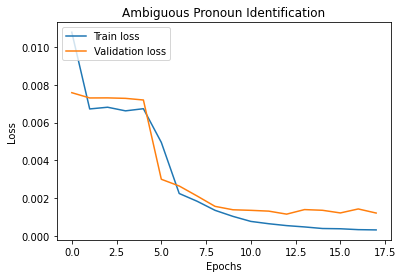

In [ ]:
plot_train_trend(loss_train, loss_val, "Ambiguous Pronoun Identification")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelPronIdent.pt"
torch.save(model, pth_model, pickle_protocol=4)

###Training and test 2

* Batch size used: 32
* Epochs of training: 10
* Loss function: Mean Squared Error
* Activation function: sigmoid
* 2 BiLSTM layer
* 1 linear layer of the classifier
* Transformer "bert-base-cased" finetuned
* Adam Optimizer

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 50
LOSS = nn.MSELoss()

In [ ]:
#instance of the model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model2 = AmbiguousPronounIdentification(N_HIDDEN,N_CLASSES)
model2.to(device)
optimizer = torch.optim.Adam(model2.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model2.train()
loss_train, loss_val = train(model2, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/50
Training...
Train Loss: 0.01360224893261843
Validating...
Validation Loss: 0.0073534735478460785


epoch: 2/50
Training...
Train Loss: 0.006809082199983737
Validating...
Validation Loss: 0.007261363416910171


epoch: 3/50
Training...
Train Loss: 0.006746556998833138
Validating...
Validation Loss: 0.007680592220276594


epoch: 4/50
Training...
Train Loss: 0.006766196091056747
Validating...
Validation Loss: 0.007273732963949442


epoch: 5/50
Training...
Train Loss: 0.00678847788778298
Validating...
Validation Loss: 0.007369366940110922


epoch: 6/50
Training...
Train Loss: 0.0067510220003040395
Validating...
Validation Loss: 0.007179484469816089


epoch: 7/50
Training...
Train Loss: 0.006679329980055199
Validating...
Validation Loss: 0.007194415153935552


epoch: 8/50
Training...
Train Loss: 0.006679690267671557
Validating...
Validation Loss: 0.0072586183901876215


epoch: 9/50
Training...
Train Loss: 0.0064404491718639345
Validating...
Validation Loss: 0.005984286870807409


In [ ]:
#Test the model
model2.eval()
true, predictions = test(model2, dataset_dev)

Identified correctly: 256
Tot: 454
# accuracy: 0.5639


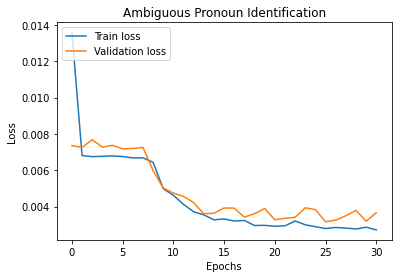

In [ ]:
plot_train_trend(loss_train, loss_val, "Ambiguous Pronoun Identification")

###Training and test 3

* Batch size used: 64/128
* Epochs of training: 10
* Loss function: Mean Squared Error
* Activation function: sigmoid
* 2 BiLSTM layer
* 1 linear layer of the classifier
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 50
LOSS = nn.MSELoss()

In [ ]:
#instance of the model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model3 = AmbiguousPronounIdentification(N_HIDDEN,N_CLASSES)
model3.to(device)
optimizer = torch.optim.Adam(model3.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batch_size = 64

In [ ]:
#Train the model
model3.train()
loss_train, loss_val = train(model3, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/50
Training...
Train Loss: 0.014524136112223184
Validating...
Validation Loss: 0.006851189956068993


epoch: 2/50
Training...
Train Loss: 0.006104181038735564
Validating...
Validation Loss: 0.006814208533614874


epoch: 3/50
Training...
Train Loss: 0.006195006036567826
Validating...
Validation Loss: 0.00655402485281229


epoch: 4/50
Training...
Train Loss: 0.006174141622343382
Validating...
Validation Loss: 0.007162394747138023


epoch: 5/50
Training...
Train Loss: 0.006244745392482294
Validating...
Validation Loss: 0.006714187376201153


epoch: 6/50
Training...
Train Loss: 0.006101191076341756
Validating...
Validation Loss: 0.006737722456455231


epoch: 7/50
Training...
Train Loss: 0.006023099997925551
Validating...
Validation Loss: 0.0065018139779567715


epoch: 8/50
Training...
Train Loss: 0.0061615459339389965
Validating...
Validation Loss: 0.006593232695013285


epoch: 9/50
Training...
Train Loss: 0.006161815865874984
Validating...
Validation Loss: 0.006499223131686449



In [ ]:
#Test the model
model3.eval()
true, predictions = test(model3, dataset_dev)

Identified correctly: 0
Tot: 454
# accuracy: 0.0000


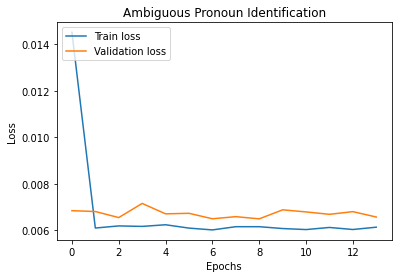

In [ ]:
plot_train_trend(loss_train, loss_val, "Ambiguous Pronoun Identification")

Batch_size = 128

In [ ]:
#Train the model
model3.train()
loss_train, loss_val = train(model3, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/50
Training...
Train Loss: 0.023246664278717202
Validating...
Validation Loss: 0.006788699422031641


epoch: 2/50
Training...
Train Loss: 0.005486728930422528
Validating...
Validation Loss: 0.006363961845636368


epoch: 3/50
Training...
Train Loss: 0.005546394280496646
Validating...
Validation Loss: 0.006670208647847176


epoch: 4/50
Training...
Train Loss: 0.005777110409160907
Validating...
Validation Loss: 0.006707731944819291


epoch: 5/50
Training...
Train Loss: 0.005652734724042768
Validating...
Validation Loss: 0.006347721442580223


epoch: 6/50
Training...
Train Loss: 0.005524674155326052
Validating...
Validation Loss: 0.006959673948585987


epoch: 7/50
Training...
Train Loss: 0.005445265507494862
Validating...
Validation Loss: 0.00686988312130173


epoch: 8/50
Training...
Train Loss: 0.005485240930945359
Validating...
Validation Loss: 0.006616642388204734


epoch: 9/50
Training...
Train Loss: 0.005377723602578044
Validating...
Validation Loss: 0.006535279254118602


e

In [ ]:
#Test the model
model3.eval()
true, predictions = test(model3, dataset_dev)

Identified correctly: 0
Tot: 454
# accuracy: 0.0000


#**Entities Identification**

##Pre-process and data organization

In [ ]:
'''
Function to find all the pronouns in the text
- args:
  - texts: list of texts [text1, ... textN]
  - pronouns: list of (pronoun, offset) of each text
  - entities: list of [(entityA,offset,True/False),(entityB,offset,True/False)]

-output:
  - new_input: list with each element organized as: {"input_ids":ids of tokens of each text, "attention_mask": mask}
  - labels: list with each element organized as: [0,0,...,1,2,0,..1,...,0] where 1 and 2 correspond to entities, 0 to other tokens;
            in particular 1 correspond to B (Beginning), 2 to I (Inside), 0 to O (Outside) of BIO tagging 
'''

def organize_data(texts, pronouns, entities):

  #tokenizer from Bert
  tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

  #store dictionaries with index and offsets of tokens
  tokens_ids, tokens_offset = find_index_offsets(texts)

  #input data
  new_input = []
  for t_id,p in zip(tokens_ids,pronouns):
    tokens = [t[0] for t in t_id.values()]

    #Add special token to represent the input as "text [SEP] pronoun [SEP]"
    tokens.append("[SEP]")
    tokens.append(p[0][0])
    tokens.append("[SEP]")

    #Build the dictionary with input_ids and mask for each text
    input_ids = []
    mask = []
    for ti in tokens:
      #covert a token into the correspondet id
      input_ids.append(torch.tensor(tokenizer(ti)[0].ids[1]))
    input_ids = torch.stack(input_ids)
    mask = torch.ones(input_ids.shape[0])
    new_input.append({"input_ids":input_ids,
                      "attention_mask":mask})
    
  #labels
  labels = []
  for t,ent in zip(tokens_offset,entities):

    label = [0.0 for _ in range(len(t)+3)]
    for e in ent:

      #split the entity to check if it is made by one or more tokens
      entity_tokens = e[0].split(" ")
      #take the offset of entity to find the correspondet token in the text (whit the tokens_offset dictionary)
      index = int(e[1])
     
      if index in t.keys():
        i = index
      #if the index of token is not present (probably due to a mismatch of tokenization)
      #then take the first avaiable token on the left of the text
      else:
        app_index=index-1
        while app_index not in t.keys():
          app_index-=1
        i = app_index

      #Add 1 (B) for the first token of the entity, 2 (I) for the nexts (if there are)
      label[t[i][1]] = 1.0
      if len(entity_tokens)>1:
        for j in range(1,len(entity_tokens)):
          label[t[i][1]+j] = 2.0

    labels.append(torch.tensor(label, requires_grad=True))

  #check if lenghts of lists match
  assert len(new_input) == len(labels) == len(tokens_ids)

  return new_input, labels, tokens_ids

In [ ]:
#Read input and labels
new_input, labels, tokens_ids = organize_data(texts, pronouns, entities)
new_input_dev, labels_dev, tokens_ids_dev = organize_data(texts_dev, pronouns_dev, entities_dev)

In [ ]:
#Store the index of the ambiguous pronoun for each text

#train set
index_pronouns = []
found = False
for t,p in zip(tokens_ids,pronouns):
  for k,v in t.items():
    if p==v: 
      index_pronouns.append(k) #take the key for which the value correspon between tokens

#dev set
index_pronouns_dev = []
found = False
for t,p in zip(tokens_ids_dev,pronouns_dev):
  for k,v in t.items():
    if p==v:
      index_pronouns_dev.append(k) #take the key for which the value correspon between tokens

In [ ]:
#organize dataset with batches
BATCH = 32

#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val, i_train, i_val = train_test_split(new_input, labels, index_pronouns, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, i_train, batch_size=BATCH, shuffle_flag=True)
dataset_val = create_dataset(x_val, y_val, i_val, batch_size=BATCH, shuffle_flag=True)
dataset_dev = create_dataset(new_input_dev, labels_dev, tokens_ids_dev, index_pronouns_dev, batch_size=BATCH, shuffle_flag=False)

##Train and test functions

In [ ]:
#train function

'''
- args:
  - model: an instance eof the model
  - optimizer: an instance of the optimizer
  - data_train: dataset for train 
  - data_val: dataset for validation
  - loss_f: loss function
  - classes: number of classes for classsficcation
  - epochs: (int) numer of epochs (default is 10)
  - train_loss: list of train losses if the training continue from previous one, None otherwise
  - val_loss: list of validation losses if the training continue from previous one, None otherwise

-output:
  - tot_loss_train: list of train losses
  - tot_loss_val: list of validation losses
'''

def train(model, optimizer, data_train, data_val, loss_f, n_classes, epochs: int = 10, train_loss = None, val_loss = None):

    #To store losses if call the train to continue a previous training or start new one
    if train_loss == None and val_loss == None: 
      tot_loss_train = []
      tot_loss_val = []
      epochs_done = 0
    else:
      tot_loss_train = train_loss
      tot_loss_val = val_loss
      assert len(tot_loss_train) == len(tot_loss_val)
      epochs_done = len(tot_loss_train)

    #Variables for early stopping
    best_validation_loss = float('inf')
    counter = 0
    patience = 5
    
    #main loop
    for epoch in range(epochs):

        print("\nepoch: "+str(epoch+1+epochs_done)+"/"+str(epochs+epochs_done))

        #training loop
        print("Training...")
        loss_train = []

        #process data
        for x, y, p in data_train:
            optimizer.zero_grad()
            input = {k: v.to(device) for k, v in x.items()}
            y = y.type(torch.long).to(device)
            out = model(input,p,y)
            #loss = loss_f(out.view(-1, n_classes), y.view(-1)) #De-comment if use Cross Entropy Loss
            loss = out #comment if use Cross Entropy Loss
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

        #loss of the batch
        lt = sum(loss_train)/len(loss_train)

        tot_loss_train.append(lt)
        print("Train Loss: "+str(lt))

        #validation loop
        print("Validating...")
        loss_val = []

        #process data
        for x, y, p in data_val:
          with torch.no_grad():
            input = {k: v.to(device) for k, v in x.items()}
            out = model(input,p)
            y = y.type(torch.long).to(device)
            #loss = loss_f(out.view(-1, n_classes), y.view(-1)) #De-comment if use Cross Entropy Loss
            loss = loss_f(out, y) #comment if use Cross Entropy Loss
            loss_val.append(loss)

        #loss of the batch
        lv = sum(loss_val)/len(loss_val)

        tot_loss_val.append(lv)
        print("Validation Loss: "+str(lv)+"\n")

        #Early Stopping
        if lv < best_validation_loss:
          best_validation_loss = lv
          counter = 0
        else:
          counter = counter+1
        if counter >= patience:
          break
    
    return tot_loss_train, tot_loss_val

In [ ]:
#test function

'''
- input:
  - model: an instance of the model
  - dataloader: dataset for test
  - true_labels: list of list of couple of entities

- output:
  - true: list of true labels (int)
  - pred: list of predictions (int)
'''

def test(model: nn.Module, dataloader: DataLoader, true_labels):

  num_correctly = 0   #number of correctly predicted (true positives)
  pred = []           #list of predictions
  true = []           #list of true labels
  n_gold = 0
  count_ones = []

  total_entities = []
  #take data, labels, list of dictionaries with {index: (token, offset)}, index of pronouns
  for x, y, t, p in dataloader:

      #predict data
      with torch.no_grad():
          input = {k: v.to(device) for k, v in x.items()}
          out = model(input, p)
          #out = torch.argmax(out, -1) #De-comment if not use CRF

      #check the predictions with true labels to compute Accuracy
      for elem_pred, ti in zip(out,t):

          found_entities = [None,None]

          for i in range(len(elem_pred)):

            #take each element of predictions
            e = elem_pred[i]

            #if the predicted element is 1 (B)
            if e==1:
              #look for first entity
              if found_entities[0] is None:
                try:
                  ent1,off1 = ti[i]
                except KeyError: #ignore if that index is not present
                  pass
                try:
                  c = 1
                  #if the predicted element is 2 (I) and follow (B)
                  while elem_pred[i+c]==2:
                    try:
                      ent1 += " "+ti[i+c][0]
                    except KeyError: #ignore if that index is not present
                      pass
                    c+=1
                except IndexError:#ignore if that index is not present
                  pass
                found_entities[0] = (ent1,off1)

              #look for second entity
              elif found_entities[1] is None:
                try:
                  ent2,off2 = ti[i]
                except KeyError: #ignore if that index is not present
                  pass
                try:
                  c = 1
                  #if the predicted element is 2 (I) and follow (B)
                  while elem_pred[i+c]==2:
                    try:
                      ent2 += " "+ti[i+c][0]
                    except KeyError: #ignore if that index is not present
                      pass
                    c+=1
                except IndexError: #ignore if that index is not present
                  pass
                found_entities[1] = (ent2,off2)
            else:
              continue #ignore if the token is predicte as 0 (Outside)

          total_entities.append(found_entities)

  #take the entities to set it as: [("entityA", offsetA),(entityB, offsetB)]
  new_entities = []
  for i in true_labels:
    new_entities.append([(i[0][0],i[0][1]),(i[1][0],i[1][1])])

  #Check how many predictions are correct
  num_correctly=0
  tot = 0
  for p,t in zip(total_entities,new_entities):
    if p[0]==t[0] or p[0]==t[1]:
      num_correctly+=1
    if p[1]==t[0] or p[1]==t[1]:
      num_correctly+=1
    tot+=2

  acc = num_correctly/tot
  print("Entities identified correctly: "+str(num_correctly))
  print("Tot entities to found: "+str(tot))
  print(f'# Accuracy: {acc:.4f}')

  return total_entities

In [ ]:
#A loss function for validation data (check how many predictions are correct)
def loss_crf_function(pred, y):
  count = 0
  for pi,yi in zip(pred,y):
    for i,j in zip(pi,yi):
      if i!=j:
        count+=1
  return count/len(pred)

##Model

In [ ]:
class EntitiesIdentification(torch.nn.Module):

    def __init__(self, n_hidden, classes, language_model_name="bert-base-cased"):
        super(EntitiesIdentification, self).__init__()

        #Transformer model
        self.transformer_model = AutoModel.from_pretrained(language_model_name, output_hidden_states=True)

        #Freeze Transformer
        #for param in self.transformer_model.parameters():
          #param.requires_grad = False

        #Number of features in output from the transformer
        self.embedding_dim = self.transformer_model.config.hidden_size

        #Additive feature to represent where is a predicate
        self.add_features = 10

        #BiLSTM layer
        self.lstm = nn.LSTM(self.embedding_dim, n_hidden, bidirectional=True, num_layers = 2, dropout=0.3, batch_first = True)

        #Linear classifier
        self.hidden1 = torch.nn.Linear(2*n_hidden+self.add_features, n_hidden)
        self.hidden2 = torch.nn.Linear(n_hidden, classes)

        #CRF layer
        self.crf = CRF(classes, batch_first = True)

    def forward(self, input: torch.Tensor=None, index_pronouns=None, tags=None):

        masks = []
        for m in input["attention_mask"]:
          masks.append(m.type(torch.bool))
        masks = torch.stack(masks)

        out = self.transformer_model(**input)
        out = torch.stack(out.hidden_states[-4:], dim=0).mean(dim=0)
        out, _ = self.lstm(out)

        #associate '1' in correspondence with the ambiguous pronoun, '0' otherwise
        new_out = []
        for oi,pi in zip(out, index_pronouns):
          o = []
          for i in range(oi.shape[0]):
            if i == pi:
              o.append(torch.cat((oi[i,:], torch.ones(self.add_features).to(device))))
            else:
              o.append(torch.cat((oi[i,:], torch.zeros(self.add_features).to(device))))
          out = torch.stack(o)
          new_out.append(out)
        new_out = torch.stack(new_out)

        #classifier
        out = self.hidden1(new_out)
        out = torch.relu(out)
        out = nn.Dropout(0.3)(out)
        out = self.hidden2(out)
        out = F.log_softmax(out,-1)

        #CRF layer
        if tags is not None:
          loss = self.crf(out, tags, mask=masks, reduction="mean") #for training mode
          return -loss
        else:
          out = self.crf.decode(out) #for evaluation mode
          return out

###Training and test 1

* Batch size used: 32
* Epochs of training: 50
* Loss function: cross_entropy
* Activation function: sigmoid
* 2 BiLSTM layer
* 1 linear layer of the classifier
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 3
EPOCHS = 10
LOSS = F.cross_entropy

In [ ]:
#instance of the model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = EntitiesIdentification(N_HIDDEN,N_CLASSES)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model.train()
loss_train, loss_val = train(model, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, 40, loss_train, loss_val)


epoch: 11/50
Training...
Train Loss: 0.005562144200153211
Validating...
Validation Loss: 0.04827373214066029


epoch: 12/50
Training...
Train Loss: 0.004004608048126102
Validating...
Validation Loss: 0.05607843156903982


epoch: 13/50
Training...
Train Loss: 0.0028964083744486904
Validating...
Validation Loss: 0.05768437422811985


epoch: 14/50
Training...
Train Loss: 0.002740764766520656
Validating...
Validation Loss: 0.0640962477773428


epoch: 15/50
Training...
Train Loss: 0.002391659069861121
Validating...
Validation Loss: 0.056259777024388315


epoch: 16/50
Training...
Train Loss: 0.002378090683658443
Validating...
Validation Loss: 0.06721407361328602


epoch: 17/50
Training...
Train Loss: 0.0013889237376347677
Validating...
Validation Loss: 0.06369936484843493


epoch: 18/50
Training...
Train Loss: 0.0012663453541737158
Validating...
Validation Loss: 0.06526930816471577


epoch: 19/50
Training...
Train Loss: 0.0013061865000910235
Validating...
Validation Loss: 0.0655173581093549

In [ ]:
#Test the model
model.eval()
ent_pred = test(model, dataset_dev, entities_dev)

Entities identified correctly: 541
Tot entities to found: 908
# Accuracy: 0.5958


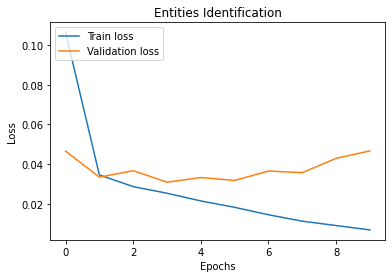

In [ ]:
plot_train_trend(loss_train, loss_val, "Entities Identification")

###Training and test 2

* Batch size used: 32
* Epochs of training: 50
* Loss function: cross_entropy
* Activation function: sigmoid
* 2 BiLSTM layer
* 2/4 linear layer of the classifier
* Transformer "bert-base-cased" not finetuned
* 1 CRF (Condition Random Field) layer
* Adam Optimizer

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 3
EPOCHS = 50
LOSS = loss_crf_function

In [ ]:
#instance of the model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model2 = EntitiesIdentification(N_HIDDEN,N_CLASSES)
model2.to(device)
optimizer = torch.optim.Adam(model2.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model2.train()
loss_train, loss_val = train(model2, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 11/50
Training...
Train Loss: 1.3700967332896063
Validating...
Validation Loss: 1.8427083333333332


epoch: 12/50
Training...
Train Loss: 1.1260158756200005
Validating...
Validation Loss: 1.9364583333333332


epoch: 13/50
Training...
Train Loss: 0.9680597666431876
Validating...
Validation Loss: 1.8864583333333331


epoch: 14/50
Training...
Train Loss: 0.7679297780289369
Validating...
Validation Loss: 1.846875


epoch: 15/50
Training...
Train Loss: 0.6635696884463815
Validating...
Validation Loss: 1.8479166666666669


epoch: 16/50
Training...
Train Loss: 0.5956107844324673
Validating...
Validation Loss: 1.8489583333333333


epoch: 17/50
Training...
Train Loss: 0.5153033601887086
Validating...
Validation Loss: 1.9020833333333331


epoch: 18/50
Training...
Train Loss: 0.42826704786104314
Validating...
Validation Loss: 1.8385416666666667


epoch: 19/50
Training...
Train Loss: 0.38486887698664385
Validating...
Validation Loss: 1.8427083333333332


epoch: 20/50
Training...
Train Loss

In [ ]:
#Test the model
model2.eval()
ent_pred = test(model2, dataset_dev, entities_dev)

Entities identified correctly: 583
Tot entities to found: 908
# Accuracy: 0.6421


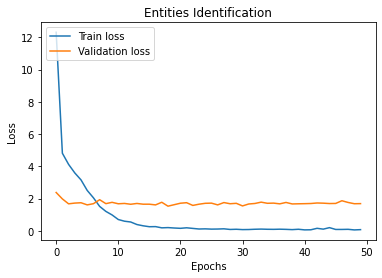

In [ ]:
plot_train_trend(loss_train, loss_val, "Entities Identification")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelEntIdent.pt"
torch.save(model, pth_model, pickle_protocol=4)

###Training and test 3
* Batch size used: 32
* Epochs of training: 50
* Loss function: cross_entropy
* Activation function: sigmoid
* 2 BiLSTM layer
* 2 linear layer of the classifier
* Transformer "bert-base-cased" finetuned
* 1 CRF (Condition Random Field) layer
* Adam Optimizer

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 3
EPOCHS = 50
LOSS = loss_crf_function

In [ ]:
#instance of the model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model3 = EntitiesIdentification(N_HIDDEN,N_CLASSES)
model3.to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001, weight_decay=0.0001)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model3.train()
loss_train, loss_val = train(model3, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, 10)


epoch: 1/10
Training...
Train Loss: 26.799508330401252
Validating...
Validation Loss: 2.9916666666666667


epoch: 2/10
Training...
Train Loss: 15.774704091689166
Validating...
Validation Loss: 2.9604166666666667


epoch: 3/10
Training...
Train Loss: 15.723820652681239
Validating...
Validation Loss: 3.0072916666666667


epoch: 4/10
Training...
Train Loss: 15.575294528288
Validating...
Validation Loss: 3.0229166666666667


epoch: 5/10
Training...
Train Loss: 15.41390047634349
Validating...
Validation Loss: 2.970833333333333


epoch: 6/10
Training...
Train Loss: 15.19307580835679
Validating...
Validation Loss: 2.986458333333333


epoch: 7/10
Training...
Train Loss: 13.945498522590189
Validating...
Validation Loss: 2.9760416666666667


epoch: 8/10
Training...
Train Loss: 13.208897063311408
Validating...
Validation Loss: 3.0125


epoch: 9/10
Training...
Train Loss: 15.217200683144963
Validating...
Validation Loss: 2.986458333333333


epoch: 10/10
Training...
Train Loss: 15.054272988263298


In [ ]:
#Test the model
model3.eval()
ent_pred = test(model3, dataset_dev, entities_dev)

Entities identified correctly: 0
Tot entities to found: 908
# Accuracy: 0.0000


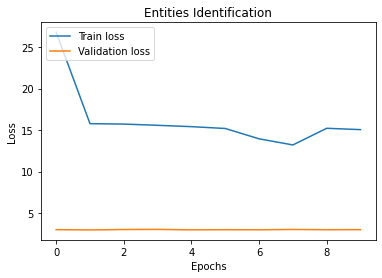

In [ ]:
plot_train_trend(loss_train, loss_val, "Entities Identification")

###Training and test 4

* Batch size used: 32
* Epochs of training: 50
* Loss function: cross_entropy
* Activation function: sigmoid
* 2 BiLSTM layer
* 2 linear layer of the classifier
* Transformer "bert-base-cased" not finetuned
* 1 CRF (Condition Random Field) layer
* Adam Optimizer
* Modify data: concatenate '1' if a token is the ambiguous pronoun, '0' othewise

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 3
EPOCHS = 50
LOSS = loss_crf_function

In [ ]:
#instance of the model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model4 = EntitiesIdentification(N_HIDDEN,N_CLASSES)
model4.to(device)
optimizer = torch.optim.Adam(model4.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model4.train()
loss_train, loss_val = train(model4, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, 10, loss_train, loss_val)


epoch: 41/50
Training...
Train Loss: 0.0780302412369672
Validating...
Validation Loss: 1.7083333333333333


epoch: 42/50
Training...
Train Loss: 0.08315105723107562
Validating...
Validation Loss: 1.6885416666666668


epoch: 43/50
Training...
Train Loss: 0.07922647386131917
Validating...
Validation Loss: 1.809375


epoch: 44/50
Training...
Train Loss: 0.09211468384601176
Validating...
Validation Loss: 1.7739583333333333


epoch: 45/50
Training...
Train Loss: 0.12458796455141376
Validating...
Validation Loss: 1.8333333333333333


epoch: 46/50
Training...
Train Loss: 0.0670016901458011
Validating...
Validation Loss: 1.7614583333333331


epoch: 47/50
Training...
Train Loss: 0.07164252042112981
Validating...
Validation Loss: 1.665625


epoch: 48/50
Training...
Train Loss: 0.06083400402875508
Validating...
Validation Loss: 1.7489583333333332


epoch: 49/50
Training...
Train Loss: 0.06036669804769404
Validating...
Validation Loss: 1.8604166666666668


epoch: 50/50
Training...
Train Loss: 0.0

In [ ]:
#Test the model
model4.eval()
ent_pred = test(model4, dataset_dev, entities_dev)

Entities identified correctly: 582
Tot entities to found: 908
# Accuracy: 0.6410


Add 10 epochs

In [ ]:
#Train the model
model4.train()
loss_train, loss_val = train(model4, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, 10, loss_train, loss_val)


epoch: 51/60
Training...
Train Loss: 0.04160146903904045
Validating...
Validation Loss: 1.5760416666666666


epoch: 52/60
Training...
Train Loss: 0.042840086011325614
Validating...
Validation Loss: 1.7614583333333331


epoch: 53/60
Training...
Train Loss: 0.07982050829073963
Validating...
Validation Loss: 1.7979166666666668


epoch: 54/60
Training...
Train Loss: 0.07836086737978108
Validating...
Validation Loss: 1.8135416666666668


epoch: 55/60
Training...
Train Loss: 0.10834284328362521
Validating...
Validation Loss: 1.6635416666666667


epoch: 56/60
Training...
Train Loss: 0.10241123998866361
Validating...
Validation Loss: 1.834375


epoch: 57/60
Training...
Train Loss: 0.10820487207349609
Validating...
Validation Loss: 1.7479166666666668


epoch: 58/60
Training...
Train Loss: 0.0802601853495135
Validating...
Validation Loss: 1.728125


epoch: 59/60
Training...
Train Loss: 0.030715558880611376
Validating...
Validation Loss: 1.6510416666666667


epoch: 60/60
Training...
Train Loss: 

In [ ]:
#Test the model
model4.eval()
ent_pred = test(model4, dataset_dev, entities_dev)

Entities identified correctly: 574
Tot entities to found: 908
# Accuracy: 0.6322


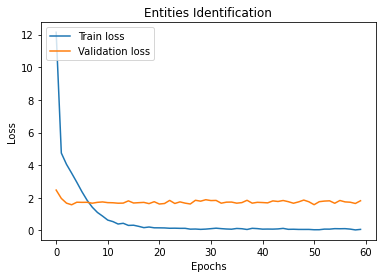

In [ ]:
plot_train_trend(loss_train, loss_val, "Entities Identification")

#**Conference Resolution**

##Pre-process and organize data

###Organization 1

Organize each text as: "[CLS] text [SEP] pronoun [SEP] entity [SEP]"

In [ ]:
'''
Function to organize data for the input of the model

- args:
  - texts: list of texts [text1, ... textN]
  - pronouns: list of (pronoun, offset) of each text
  - entities: list of [(entityA,offset,True/False),(entityB,offset,True/False)]

-output:
  - new_input: list with each element organized as: {"input_ids":ids of tokens of each text, "attention_mask": mask}
  - labels: list of '1' if the correspondet entity is related to the pronoun in question, '0' otherwise
'''

def organize_data(texts, pronouns, entities):

  #tokenizer from Bert
  tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

  #input data
  new_input = []
  labels = []

  #Pattern of data: "[CLS] text [SEP] pronoun [SEP] entity [SEP]"
  #In this casa it is considered all the text tokenized, included words tokenized as 'token1_1','##token1_2'
  for t,p,e in zip(texts,pronouns,entities):

    #first entity of dataset
    encoded = tokenizer(t,p[0]+"[SEP]"+e[0][0])
    input = {k: torch.Tensor(v) for k, v in encoded.items()}
    new_input.append(input)
    #correspondent label
    if e[0][2] =='TRUE':
      labels.append(1.0)
    else:
      labels.append(0.0)

    #second entity of the dataset
    encoded = tokenizer(t,p[0]+"[SEP]"+e[1][0])
    input = {k: torch.Tensor(v) for k, v in encoded.items()}
    #correspondet label
    new_input.append(input)
    if e[1][2] =='TRUE':
      labels.append(1.0)
    else:
      labels.append(0.0)

  assert len(new_input) == len(labels)

  return new_input, torch.Tensor(labels)

In [ ]:
#Organize data
new_input, labels = organize_data(texts,pronouns,entities)
new_input_dev, labels_dev = organize_data(texts_dev,pronouns_dev,entities_dev)

In [ ]:
#organize dataset with batches
BATCH = 32

#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(new_input, labels, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, batch_size=BATCH, shuffle_flag=True)
dataset_val = create_dataset(x_val, y_val, batch_size=BATCH, shuffle_flag=True)
dataset_dev = create_dataset(new_input_dev, labels_dev, batch_size=BATCH, shuffle_flag=False)

###Organization 2

Organize data as: "tokens text [SEP] pronoun [SEP] entity"

This is the implementation used for the model considered

In [ ]:
'''
Function to find the indecies of pronoun and entities in the text (number of token)

- args:
  - tokenizer
  - tokens_ids: list of dictionaries of tokens 
  - pronouns: list of (pronoun, offset) of each text
  - entities: list of [(entityA,offset,True/False),(entityB,offset,True/False)]

-output:
  - indicies_of_interest: couples of indicies to indicate the tokens of pronoun and entity in the text
'''

def find_indicies_of_interest(tokenizer, tokens_ids, pronouns, entities):

  #Save the token index of each entity in the text 
  index_entities = []
  found = False
  for t,ent in zip(tokens_ids,entities):
    for e in ent:
      entity = (e[0].split(" ")[0],e[1])
      #check for the entity between the token to find its index
      for k,v in t.items():
        if entity==v:
          index_entities.append(k)
          found = True
      if not found:
        index_entities.append(None)
      else:
        found = False

  #Save the token index of each pronoun in the text
  index_pronouns = []
  found = False
  for t,p in zip(tokens_ids,pronouns):
    #check for the pronoun between the token to find its index
    for k,v in t.items():
      if p==v:
        #add the pronoun twice beacuse the entities list is flatten:
        #each couple refered to the same pronoun [(entity1A,entity1B), (entity2A,entity2B), ...]
        #beacome [entity1A, entity1B, entity2A, entity2B, ...]
        index_pronouns.append(k)
        index_pronouns.append(k)

  #Save the indicies in coples
  index_of_interest = []
  #list of saved indicies become [(index pronoun1, (index entity1A, index entity1B)),
  #                               (index pronoun2, (index entity2A, index entity2B)), ... ]
  for i1,i2 in zip(index_entities,index_pronouns):
    index_of_interest.append((i1,i2))

  return index_of_interest

In [ ]:
'''
Function to organize data for the input of the model

- args:
  - texts: list of texts [text1, ... textN]
  - pronouns: list of (pronoun, offset) of each text
  - entities: list of [(entityA,offset,True/False),(entityB,offset,True/False)]

-output:
  - new_input: list with each element organized as: {"input_ids":ids of tokens of each text, "attention_mask": mask}
  - labels: list of '1' if the correspondet entity is related to the pronoun in question, '0' otherwise
  - indicies_of_interest: couples of indicies to indicate the tokens of pronoun and entity in the text
  - tokens_entity: number of tokens for each entity
'''

def organize_data2(texts, pronouns, entities):

  #tokenizer from Bert
  tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

  #Find ids and offset of each word
  tokens_ids, tokens_offset = find_index_offsets(texts)
  indicies_of_interest = find_indicies_of_interest(tokenizer, tokens_ids, pronouns, entities)
  
  new_input = []
  labels = []
  tokens_entity = []

  #Pattern of data: "text [SEP] pronoun [SEP] entity"
  #In this casa it is considered all first token of tokenized text, (the root of the word)
  for t_id,p,e in zip(tokens_ids,pronouns,entities):

    input_ids = []
    input_idsA = []
    input_idsB = []
    maskA = []
    maskB = []

    #tokenize all text
    tokens = [t[0] for t in t_id.values()]
    input_ids = [torch.tensor(tokenizer(ti)[0].ids[1]) for ti in tokens]
    input_ids.append(torch.tensor(tokenizer("[SEP]")[0].ids[1]))
    input_ids.append(torch.tensor(tokenizer(p[0])[0].ids[1]))
    input_ids.append(torch.tensor(tokenizer("[SEP]")[0].ids[1]))

    #add first entity
    input_idsA = copy.deepcopy(input_ids)
    entity = tokenizer.tokenize(e[0][0])
    token_entity = 0
    for i in entity:
      #convert token into the correspondet id
      input_idsA.append(torch.tensor(tokenizer(i)[0].ids[1]))
      token_entity+=1
    tokens_entity.append(token_entity)
    input_idsA = torch.stack(input_idsA)
    maskA = torch.ones(input_idsA.shape[0])
    
    #correspondet label
    if e[0][2] =='TRUE':
      labels.append(1.0)
    else:
      labels.append(0.0)

    #add second entity
    input_idsB = copy.deepcopy(input_ids)
    entity = tokenizer.tokenize(e[1][0])
    token_entity = 0
    for i in entity:
      #convert token into the correspondet id
      input_idsB.append(torch.tensor(tokenizer(i)[0].ids[1]))
      token_entity+=1
    tokens_entity.append(token_entity)
    input_idsB = torch.stack(input_idsB)
    maskB = torch.ones(input_idsB.shape[0])

    #correspondent label
    if e[1][2] =='TRUE':
      labels.append(1.0)
    else:
      labels.append(0.0)

    #Add the processed data to a list for the final input shape
    new_input.append({"input_ids":input_idsA,"attention_mask":maskA})
    new_input.append({"input_ids":input_idsB,"attention_mask":maskB})

  #check if lenghts of lists match
  assert len(new_input) == len(labels) == len(tokens_entity)

  return new_input, torch.Tensor(labels), indicies_of_interest, tokens_entity

In [ ]:
#Organize data
new_input, labels, index_of_interest, tokens_entity = organize_data2(texts,pronouns,entities)
new_input_dev, labels_dev, index_of_interest_dev, tokens_entity_dev = organize_data2(texts_dev,pronouns_dev,entities_dev)

In [ ]:
#organize dataset with batches
BATCH = 32

#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val, i_train, i_val, t_train, t_val = train_test_split(new_input, labels, index_of_interest, tokens_entity, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, i_train, t_train, batch_size=BATCH, shuffle_flag=True)
dataset_val = create_dataset(x_val, y_val, i_val, t_val, batch_size=BATCH, shuffle_flag=True)
dataset_dev = create_dataset(new_input_dev, labels_dev, index_of_interest_dev, tokens_entity_dev, batch_size=BATCH, shuffle_flag=False)

##Train and test functions

In [ ]:
'''
- args:
  - model: an instance eof the model
  - optimizer: an instance of the optimizer
  - data_train: dataset for train 
  - data_val: dataset for validation
  - loss_f: loss function
  - classes: number of classes for classsficcation
  - epochs: (int) numer of epochs (default is 10)
  - train_loss: list of train losses if the training continue from previous one, None otherwise
  - val_loss: list of validation losses if the training continue from previous one, None otherwise

-output:
  - tot_loss_train: list of train losses
  - tot_loss_val: list of validation losses
'''

def train(model, optimizer, data_train, data_val, loss_f, n_classes, epochs: int = 10, train_loss = None, val_loss = None):

    #To store losses if call the train to continue a previous training or start new one
    if train_loss == None and val_loss == None: 
      tot_loss_train = []
      tot_loss_val = []
      epochs_done = 0
    else:
      tot_loss_train = train_loss
      tot_loss_val = val_loss
      assert len(tot_loss_train) == len(tot_loss_val)
      epochs_done = len(tot_loss_train)

    #Variables for early stopping
    best_validation_loss = float('inf')
    counter = 0
    patience = 7
    
    #main loop
    for epoch in range(epochs):

        print("\nepoch: "+str(epoch+1+epochs_done)+"/"+str(epochs+epochs_done))

        #training loop
        print("Training...")
        loss_train = []

        #process data
        for x, y, i, t in data_train:
            optimizer.zero_grad()
            input = {k: v.type(torch.long).to(device) for k, v in x.items()}
            out = model(input, i, t)
            out = out.type(torch.float).to(device)
            y = torch.Tensor(y)
            y = y.type(torch.float).to(device)
            y.requires_grad=True
            loss = loss_f(out, y)
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

        #loss of the batch
        lt = sum(loss_train)/len(loss_train)

        tot_loss_train.append(lt)
        print("Train Loss: "+str(lt))

        #validation loop
        print("Validating...")
        loss_val = []

        #process data
        for x, y, i, t in data_val:
          with torch.no_grad():
            input = {k: v.type(torch.long).to(device) for k, v in x.items()}
            out = model(input, i, t)
            out = out.type(torch.float).to(device)
            y = torch.Tensor(y)
            y = y.type(torch.float).to(device)
            loss = loss_f(out, y)
            loss_val.append(loss.item())

        #loss of the batch
        lv = sum(loss_val)/len(loss_val)

        tot_loss_val.append(lv)
        print("Validation Loss: "+str(lv)+"\n")

        #Early Stopping
        if lv < best_validation_loss:
          best_validation_loss = lv
          counter = 0
        else:
          counter = counter+1
        if counter >= patience:
          break
    
    return tot_loss_train, tot_loss_val

In [ ]:
#test function

'''
- input:
  - model: an instance of the model
  - dataloader: dataset for test

- output:
  - true: list of true labels (int)
  - pred: list of predictions (int)
'''

def test(model: nn.Module, dataloader: DataLoader):

  true_positive = 0   #TRUE POSITIVES
  false_positive = 0  #FALSE POSITIVES
  true_negative = 0   #TRUE NEGATIVES
  false_negative = 0  #FALSE NEGATIVES
  pred = []           #list of predictions
  true = []           #list of true labels
  device = "cuda" if torch.cuda.is_available() else "cpu"

  for x, y, i, t in dataloader:

      #predict data
      with torch.no_grad():
          input = {k: v.type(torch.long).to(device) for k, v in x.items()}
          out = model(input, i, t)
          out = torch.round(out).to(device)

      #check the predictions with true labels to compute Accuracy and F1
      for elem_pred, elem_true in zip(out.to(device), y):

          if elem_pred == 1 and elem_true ==1: 
            true_positive += 1
          elif elem_pred == 0 and elem_true ==0:
            true_negative += 1
          elif elem_pred == 0 and elem_true ==1:
            false_negative += 1
          elif elem_pred == 1 and elem_true ==0:
            false_positive += 1

          true.append(elem_true)
          pred.append(elem_pred)

  tot_correctly = true_positive+true_negative #total predicted correctly
  tot = true_positive+true_negative+false_negative+false_positive #total samples
  acc = tot_correctly/tot #accuracy

  precision = true_positive/(true_positive+false_positive) #precision
  recall = true_positive/(true_positive+false_negative) #recall
  F1 = 2*(precision*recall)/(precision+recall) #F1

  print("Identified correctly: "+str(tot_correctly))
  print("Tot: "+str(tot))
  print(f'# Precision: {precision:.4f}')
  print(f'# Recall: {recall:.4f}')
  print(f'# F1: {F1:.4f}')
  print(f'# accuracy: {acc:.4f}')
  
  return true, pred

In [ ]:
#test function on more models for ensambling

'''
- input:
  - model: list of instances of model
  - dataloader: dataset for test

- output:
  - true: list of true labels (int)
  - pred: list of predictions (int)
'''

def test_ensamble(models: list, model2: nn.Module, dataloader: DataLoader):

  true_positive = 0   #TRUE POSITIVES
  false_positive = 0  #FALSE POSITIVES
  true_negative = 0   #TRUE NEGATIVES
  false_negative = 0  #FALSE NEGATIVES
  pred = []           #list of predictions
  true = []           #list of true labels
  device = "cuda" if torch.cuda.is_available() else "cpu"

  for x, y, i, t in dataloader:

      #predict data
      with torch.no_grad():
          input = {k: v.type(torch.long).to(device) for k, v in x.items()}
          out = torch.zeros(input["input_ids"].shape[0]).to(device)
          #predict the output for each model in the input list
          for model in models:
            out += model(input, i, t)
          out = out/len(models) #mean of predictions
          out = torch.round(out)

      #check the predictions with true labels to compute Accuracy and F1
      for elem_pred, elem_true in zip(out.to(device), y):

          if elem_pred == 1 and elem_true ==1: 
            true_positive += 1
          elif elem_pred == 0 and elem_true ==0:
            true_negative += 1
          elif elem_pred == 0 and elem_true ==1:
            false_negative += 1
          elif elem_pred == 1 and elem_true ==0:
            false_positive += 1

          true.append(elem_true)
          pred.append(elem_pred)

  tot_correctly = true_positive+true_negative #total predicted correctly
  tot = true_positive+true_negative+false_negative+false_positive #total samples
  acc = tot_correctly/tot #accuracy

  precision = true_positive/(true_positive+false_positive) #precision
  recall = true_positive/(true_positive+false_negative) #recall
  F1 = 2*(precision*recall)/(precision+recall) #F1

  print("Identified correctly: "+str(tot_correctly))
  print("Tot: "+str(tot))
  print(f'# Precision: {precision:.4f}')
  print(f'# Recall: {recall:.4f}')
  print(f'# F1: {F1:.4f}')
  print(f'# accuracy: {acc:.4f}')
  
  return true, pred

##Model

In [ ]:
class ConferenceResolution(torch.nn.Module):

    def __init__(self, n_hidden, classes, language_model_name="bert-base-cased"):
        super(ConferenceResolution, self).__init__()

        #Transformer model
        self.transformer_model = AutoModel.from_pretrained(language_model_name, output_hidden_states=True)

        #Freeze Transformer
        for param in self.transformer_model.parameters():
          param.requires_grad = False

        #Number of features in output from the transformer
        self.embedding_dim = self.transformer_model.config.hidden_size

        #Additive feature to represent where is a predicate
        self.add_features = 0

        #BiLSTM layer
        self.lstm = nn.LSTM(self.embedding_dim+self.add_features, n_hidden, bidirectional=True, num_layers = 2, dropout=0.3, batch_first = True)

        #Linear classifier
        self.hidden1 = torch.nn.Linear(2*n_hidden, n_hidden)
        self.hidden2 = torch.nn.Linear(n_hidden, classes)

    def forward(self, input: torch.Tensor = None, index=None, lenghts=None):

        out = self.transformer_model(**input)
        out = torch.stack(out.hidden_states[-4:], dim=0).mean(dim=0)
        out, _ = self.lstm(out)

        new_out = []

        for output,mask,i,l in zip(out,input["attention_mask"],index,lenghts):
          #take the representation without pad

          new_representation = []
          for o,m in zip(output,mask):
            if m == 1:
              new_representation.append(o)

          #o1 = torch.stack(new_representation[-l:-1]) #to take the entity concatenated at the end (may be more tokens)
          #o2 = new_representation[-l-2] #to take the pronoun concatenated at the end (one token)

          i1 = i[0] #index of entity
          i2 = i[1] #index of pronoun

          #Entity: if the index is found, take the mean of entity tokens
          if i1 is not None:
            if l>1:
              o1 = torch.stack(new_representation[i1:i1+l])
              o1 = torch.mean(o1)
            else:
              o1 = new_representation[i1]
          #otherwise take the mean of all words of the text
          else:
            o1 = torch.mean(output, -2)

          #Pronoun: if the index is found, take the correspondet token
          if i2 is not None:
            o2 = new_representation[i2]
          else:
            #otherwise take the mean of all words of the text
            o2 = torch.mean(output, -2)

          #take the sum between pronoun and entity
          new_out.append((o1+o2))

        #transform list in tensor
        new_out = torch.stack(new_out)

        #classification
        out = self.hidden1(new_out)
        out = torch.relu(out)
        out = nn.Dropout(0.3)(out)
        out = self.hidden2(out)

        #activation function
        out = torch.sigmoid(out)
        
        return out.squeeze(-1)

###Training and test 1

* Batch size used: 32
* Epochs of training: 10
* Loss function: MSE
* Activation function: sigmoid
* 2 BiLSTM layer
* 2 linear layer of the classifier
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer
* Data: "[CLS] text [SEP] pronoun [SEP] entity [SEP]" -> mean of all words

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.MSELoss()

In [ ]:
#instance of the model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConferenceResolution(N_HIDDEN,N_CLASSES)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model.train()
loss_train, loss_val = train(model, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.24810231578420605
Validating...
Validation Loss: 0.2498347853359423


epoch: 2/10
Training...
Train Loss: 0.239411936973679
Validating...
Validation Loss: 0.2116697195329164


epoch: 3/10
Training...
Train Loss: 0.20296775412982737
Validating...
Validation Loss: 0.19832512187330345


epoch: 4/10
Training...
Train Loss: 0.18721415446354792
Validating...
Validation Loss: 0.1869323990846935


epoch: 5/10
Training...
Train Loss: 0.18025011525175275
Validating...
Validation Loss: 0.20054375262636887


epoch: 6/10
Training...
Train Loss: 0.1736360864173731
Validating...
Validation Loss: 0.18034412633431585


epoch: 7/10
Training...
Train Loss: 0.1657057465357188
Validating...
Validation Loss: 0.1847922096126958


epoch: 8/10
Training...
Train Loss: 0.15986354724013593
Validating...
Validation Loss: 0.18135436741929306


epoch: 9/10
Training...
Train Loss: 0.15221499166721422
Validating...
Validation Loss: 0.17778472680794566


epoch: 10/10
Training...
T

In [ ]:
#Test the model
model.eval()
true, predictions = test(model, dataset_dev)

Identified correctly: 643
Tot: 908
# Precision: 0.6320
# Recall: 0.7755
# F1: 0.6964
# accuracy: 0.7081


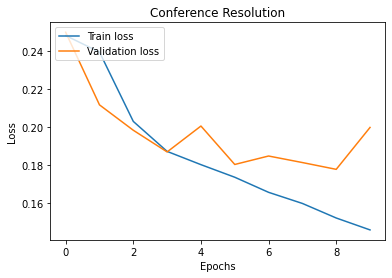

In [ ]:
plot_train_trend(loss_train, loss_val, "Conference Resolution")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelConfResSecondTry.pt"
torch.save(model, pth_model, pickle_protocol=4)

###Training and test 2

* Batch size used: 32
* Epochs of training: 10
* Loss function: MSE
* Activation function: sigmoid
* 2 BiLSTM layer
* 2 linear layer of the classifier
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer
* Data: "[CLS] text [SEP] pronoun [SEP] entity [SEP]" taking only pronoun+entity

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.MSELoss()

In [ ]:
#instance of the model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model2 = ConferenceResolution(N_HIDDEN,N_CLASSES)
model2.to(device)
optimizer = torch.optim.Adam(model2.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model2.train()
loss_train, loss_val = train(model2, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.2167968223609868
Validating...
Validation Loss: 0.18908646624339254


epoch: 2/10
Training...
Train Loss: 0.1859327561756563
Validating...
Validation Loss: 0.18521500025924884


epoch: 3/10
Training...
Train Loss: 0.1770631075346258
Validating...
Validation Loss: 0.17388791120366046


epoch: 4/10
Training...
Train Loss: 0.16567896747377497
Validating...
Validation Loss: 0.1907833351900703


epoch: 5/10
Training...
Train Loss: 0.15581442539155835
Validating...
Validation Loss: 0.18082314415981895


epoch: 6/10
Training...
Train Loss: 0.1481353002187063
Validating...
Validation Loss: 0.18404228710814527


epoch: 7/10
Training...
Train Loss: 0.13467176188025953
Validating...
Validation Loss: 0.20502103708292307


epoch: 8/10
Training...
Train Loss: 0.12317386679571761
Validating...
Validation Loss: 0.19956420205141367


epoch: 9/10
Training...
Train Loss: 0.11124613565894273
Validating...
Validation Loss: 0.20782892523627533


epoch: 10/10
Training..

In [ ]:
#Test the model
model2.eval()
true, predictions = test(model2, dataset_dev)

Identified correctly: 617
Tot: 908
# Precision: 0.6253
# Recall: 0.6429
# F1: 0.6340
# accuracy: 0.6795


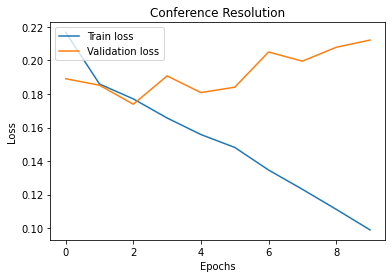

In [ ]:
plot_train_trend(loss_train, loss_val, "Conference Resolution")

###Training and test 3

* Batch size used: 32
* Epochs of training: 10
* Loss function: MSE
* Activation function: sigmoid
* 2 BiLSTM layer
* 2 linear layer of the classifier
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer
* Data: "text_tokens [SEP] pronoun [SEP] entity " taking only pronoun+entity from tokens in the text
* **OSS.:** this block contain a confusion matrix

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.MSELoss()

In [ ]:
#instance of the model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model3 = ConferenceResolution(N_HIDDEN,N_CLASSES)
model3.to(device)
optimizer = torch.optim.Adam(model3.parameters())

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model.train()
loss_train, loss_val = train(model, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.21444240913412274
Validating...
Validation Loss: 0.14677627737584867


epoch: 2/10
Training...
Train Loss: 0.14358995951844392
Validating...
Validation Loss: 0.15284436078448044


epoch: 3/10
Training...
Train Loss: 0.11262605134287529
Validating...
Validation Loss: 0.1330234596603795


epoch: 4/10
Training...
Train Loss: 0.07918652560363507
Validating...
Validation Loss: 0.13865962193200462


epoch: 5/10
Training...
Train Loss: 0.05994886413392936
Validating...
Validation Loss: 0.1407509444183425


epoch: 6/10
Training...
Train Loss: 0.03809530271069814
Validating...
Validation Loss: 0.13812515414074847


epoch: 7/10
Training...
Train Loss: 0.030066113582646582
Validating...
Validation Loss: 0.14090773698530698


epoch: 8/10
Training...
Train Loss: 0.024640372685399925
Validating...
Validation Loss: 0.1277250424027443


epoch: 9/10
Training...
Train Loss: 0.02299232282349461
Validating...
Validation Loss: 0.1298167310459049


epoch: 10/10
Trainin

In [ ]:
#Test the model
model3.eval()
true, predictions = test(model3, dataset_dev)

Identified correctly: 733
Tot: 908
# Precision: 0.7494
# Recall: 0.8316
# F1: 0.7884
# accuracy: 0.8073


In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelEntRes.pt"
torch.save(model, pth_model, pickle_protocol=4)

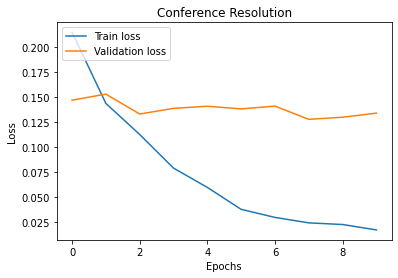

In [ ]:
plot_train_trend(loss_train, loss_val, "Conference Resolution")

Confusion Matrix


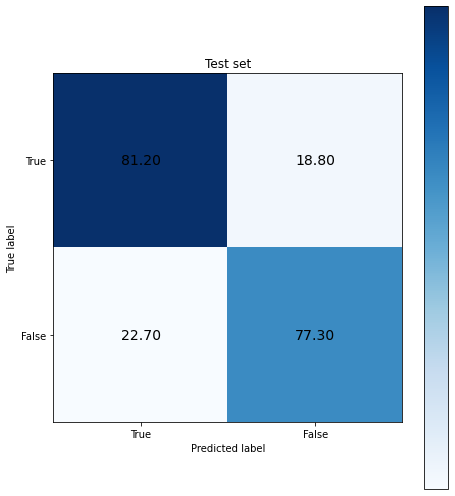

In [ ]:
#confusion matrix
plot_confusion_matrix(np.array(true), np.array(predictions), ['True','False'])

Using Binary Cross Entropy loss

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.BCELoss()

In [ ]:
#instance of the model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model3 = ConferenceResolution(N_HIDDEN,N_CLASSES)
model3.to(device)
optimizer = torch.optim.Adam(model3.parameters())

In [ ]:
#Train the model
model3.train()
loss_train, loss_val = train(model3, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.5780162326330264
Validating...
Validation Loss: 0.44612092877689163


epoch: 2/10
Training...
Train Loss: 0.4181030126365684
Validating...
Validation Loss: 0.4293195228827627


epoch: 3/10
Training...
Train Loss: 0.3421636832183635
Validating...
Validation Loss: 0.43285376460928665


epoch: 4/10
Training...
Train Loss: 0.2472438602405187
Validating...
Validation Loss: 0.5305362908463729


epoch: 5/10
Training...
Train Loss: 0.1812524793327913
Validating...
Validation Loss: 0.49855580141669825


epoch: 6/10
Training...
Train Loss: 0.11443329331349339
Validating...
Validation Loss: 0.5585901423504478


epoch: 7/10
Training...
Train Loss: 0.0864359118463196
Validating...
Validation Loss: 0.6868022382259369


epoch: 8/10
Training...
Train Loss: 0.05769970989717204
Validating...
Validation Loss: 0.6840160912589023


epoch: 9/10
Training...
Train Loss: 0.05007865004304841
Validating...
Validation Loss: 0.6724769147603136



In [ ]:
#Test the model# last tokens of sentence (summed) and data with organize_data
model3.eval()
true, predictions = test(model3, dataset_dev)

Identified correctly: 711
Tot: 908
# Precision: 0.7546
# Recall: 0.7372
# F1: 0.7458
# accuracy: 0.7830


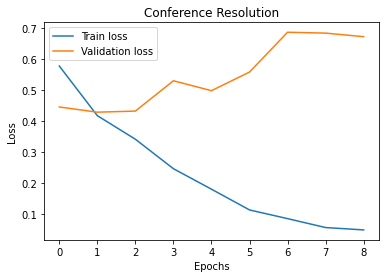

In [ ]:
plot_train_trend(loss_train, loss_val, "Conference Resolution")

###Training and test 4

* Batch size used: 32
* Epochs of training: 10
* Loss function: MSE
* Activation function: sigmoid
* 2 BiLSTM layer
* 2 linear layer of the classifier
* Transformer "bert-base-cased" finetuned
* Adam Optimizer
* Data: "text_tokens" taking only pronoun+entity from tokens in the text

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.MSELoss()

In [ ]:
#instance of the model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model4 = ConferenceResolution(N_HIDDEN,N_CLASSES)
model4.to(device)
optimizer = torch.optim.Adam(model4.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model4.train()
loss_train, loss_val = train(model4, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.2213997750945345
Validating...
Validation Loss: 0.14989211410284042


epoch: 2/10
Training...
Train Loss: 0.1469475185862307
Validating...
Validation Loss: 0.1548485963752395


epoch: 3/10
Training...
Train Loss: 0.12792487285987159
Validating...
Validation Loss: 0.15461798325965279


epoch: 4/10
Training...
Train Loss: 0.11057038131285701
Validating...
Validation Loss: 0.14223242472661168


epoch: 5/10
Training...
Train Loss: 0.08937540842143037
Validating...
Validation Loss: 0.15018846055394725


epoch: 6/10
Training...
Train Loss: 0.07560020873664751
Validating...
Validation Loss: 0.14246369388542676


epoch: 7/10
Training...
Train Loss: 0.05456005822944306
Validating...
Validation Loss: 0.14461038457719902


epoch: 8/10
Training...
Train Loss: 0.04472416844604724
Validating...
Validation Loss: 0.1519791440744149


epoch: 9/10
Training...
Train Loss: 0.037698515614401
Validating...
Validation Loss: 0.1515134757286624


epoch: 10/10
Training...


In [ ]:
#Test the model
model4.eval()
true, predictions = test(model4, dataset_dev)

Identified correctly: 705
Tot: 908
# Precision: 0.7632
# Recall: 0.6990
# F1: 0.7297
# accuracy: 0.7764


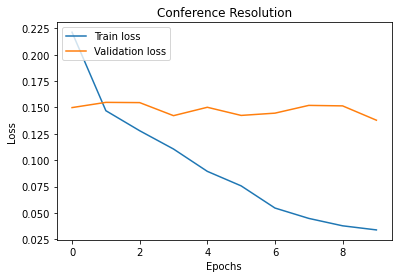

In [ ]:
plot_train_trend(loss_train, loss_val, "Conference Resolution")

###Test and training 5

* Batch size used: 32
* Epochs of training: 10
* Loss function: MSE
* Activation function: sigmoid
* 2 BiLSTM layer
* 2 linear layer of the classifier
* Transformer "bert-base-cased", "xml-roberta-base" and "roberta-base" not finetuned
* Adam Optimizer
* Data: "text_tokens" taking only pronoun+entity from tokens in the text
* Ensambling between the three models

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.MSELoss()

In [ ]:
#instance of the model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConferenceResolution(N_HIDDEN,N_CLASSES,"bert-base-cased")
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model.train()
loss_train, loss_val = train(model, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.20023985405469083
Validating...
Validation Loss: 0.16143870667407387


epoch: 2/10
Training...
Train Loss: 0.13869673130515764
Validating...
Validation Loss: 0.14382494044931313


epoch: 3/10
Training...
Train Loss: 0.11021100187442712
Validating...
Validation Loss: 0.1395311822232447


epoch: 4/10
Training...
Train Loss: 0.07787903918493429
Validating...
Validation Loss: 0.14423093670292905


epoch: 5/10
Training...
Train Loss: 0.056998613147208325
Validating...
Validation Loss: 0.1420210864590971


epoch: 6/10
Training...
Train Loss: 0.03842852178157842
Validating...
Validation Loss: 0.12903184424105443


epoch: 7/10
Training...
Train Loss: 0.033525177664068366
Validating...
Validation Loss: 0.13170938938856125


epoch: 8/10
Training...
Train Loss: 0.024528241818102585
Validating...
Validation Loss: 0.1386232830976185


epoch: 9/10
Training...
Train Loss: 0.023122477710258063
Validating...
Validation Loss: 0.13407590201026515


epoch: 10/10
Trai

In [ ]:
#Test the model# last tokens of sentence (summed) and data with organize_data
model.eval()
true, predictions = test(model, dataset_dev)

Identified correctly: 708
Tot: 908
# Precision: 0.7275
# Recall: 0.7832
# F1: 0.7543
# accuracy: 0.7797


In [ ]:
#instance of the model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model2 = ConferenceResolution(N_HIDDEN,N_CLASSES,device, language_model_name= "xml-roberta-base")
model2.to(device)
optimizer = torch.optim.Adam(model2.parameters())

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model2.train()
loss_train, loss_val = train(model2, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.2316726373850241
Validating...
Validation Loss: 0.17723819613456726


epoch: 2/10
Training...
Train Loss: 0.1708575466857154
Validating...
Validation Loss: 0.15671936069664202


epoch: 3/10
Training...
Train Loss: 0.1517278705916461
Validating...
Validation Loss: 0.15741826633089467


epoch: 4/10
Training...
Train Loss: 0.13403884279569225
Validating...
Validation Loss: 0.16142763707198596


epoch: 5/10
Training...
Train Loss: 0.11356375895484665
Validating...
Validation Loss: 0.15531204954573982


epoch: 6/10
Training...
Train Loss: 0.09088485873684551
Validating...
Validation Loss: 0.1661473583233984


epoch: 7/10
Training...
Train Loss: 0.07580088119755482
Validating...
Validation Loss: 0.14090513320345627


epoch: 8/10
Training...
Train Loss: 0.05837358157122893
Validating...
Validation Loss: 0.16287757142593987


epoch: 9/10
Training...
Train Loss: 0.04727389230103557
Validating...
Validation Loss: 0.17027811745279714


epoch: 10/10
Training.

In [ ]:
#Test the model# last tokens of sentence (summed) and data with organize_data
model2.eval()
true, predictions = test(model2, dataset_dev)

Identified correctly: 692
Tot: 908
# Precision: 0.7189
# Recall: 0.7372
# F1: 0.7280
# accuracy: 0.7621


In [ ]:
#instance of the model and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model3 = ConferenceResolution(N_HIDDEN,N_CLASSES,device, "roberta-base")
model3.to(device)
optimizer = torch.optim.Adam(model3.parameters())

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model3.train()
loss_train, loss_val = train(model3, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.24836532189648533
Validating...
Validation Loss: 0.2376905930669684


epoch: 2/10
Training...
Train Loss: 0.19609432760075
Validating...
Validation Loss: 0.18996822324238324


epoch: 3/10
Training...
Train Loss: 0.1726201010438112
Validating...
Validation Loss: 0.1761563883015984


epoch: 4/10
Training...
Train Loss: 0.1593460195956851
Validating...
Validation Loss: 0.16847321861668638


epoch: 5/10
Training...
Train Loss: 0.14388510051387302
Validating...
Validation Loss: 0.16792909526511243


epoch: 6/10
Training...
Train Loss: 0.1296033573573863
Validating...
Validation Loss: 0.1641787286651762


epoch: 7/10
Training...
Train Loss: 0.11400188421885643
Validating...
Validation Loss: 0.1812182727612947


epoch: 8/10
Training...
Train Loss: 0.0982397263594104
Validating...
Validation Loss: 0.174189849903709


epoch: 9/10
Training...
Train Loss: 0.0818639304984868
Validating...
Validation Loss: 0.18510440305659645


epoch: 10/10
Training...
Train L

In [ ]:
#Test the model# last tokens of sentence (summed) and data with organize_data
model3.eval()
true, predictions = test(model3, dataset_dev)

Identified correctly: 670
Tot: 908
# Precision: 0.6860
# Recall: 0.7245
# F1: 0.7047
# accuracy: 0.7379


Ensambling

In [ ]:
#Ensamble
true, predictions = test_ensamble([model, model2, model3], model, dataset_dev)

Identified correctly: 684
Tot: 908
# Precision: 0.7165
# Recall: 0.7092
# F1: 0.7128
# accuracy: 0.7533


In [ ]:
#move data on cpu and store in a list to copute confusion matrix
true= [t.cpu() for t in true]
predictions = [p.cpu() for p in predictions]

Confusion Matrix


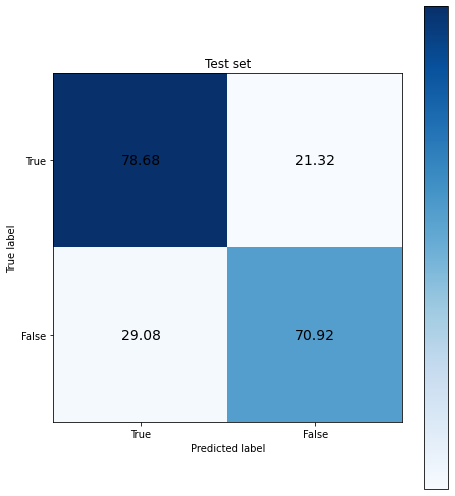

In [ ]:
#confusion matrix
plot_confusion_matrix(np.array(true), np.array(predictions), ['True','False'])

##Approach 2

In this section I train a model made by Bert+BiLSTM and an autoencoder, from the latter i will reduce dimensionality of data using the encoder part of the Autoencoder to reduce the output of the fisrt model. The final encoded output will train a Support Vector Machine for binary classification.

###Re-organize dataset

In [ ]:
#define train and dev set for the svm
BATCH = 32
dataset_train_svm = create_dataset(new_input, labels, index_of_interest, tokens_entity, batch_size=BATCH, shuffle_flag=True)
dataset_dev_svm = create_dataset(new_input_dev, labels_dev, index_of_interest_dev, tokens_entity_dev, batch_size=BATCH, shuffle_flag=False)

###Train and test functions

In [ ]:
#test function to train the data representation

'''
- args:
  - model: an instance eof the model
  - optimizer: an instance of the optimizer
  - data_train: dataset for train 
  - data_val: dataset for validation
  - loss_f: loss function
  - classes: number of classes for classsficcation
  - epochs: (int) numer of epochs (default is 10)
  - train_loss: list of train losses if the training continue from previous one, None otherwise
  - val_loss: list of validation losses if the training continue from previous one, None otherwise

-output:
  - tot_loss_train: list of train losses
  - tot_loss_val: list of validation losses
'''

def train(model, optimizer, data_train, data_val, loss_f, n_classes, epochs: int = 10, train_loss = None, val_loss = None):

    #To store losses if call the train to continue a previous training or start new one
    if train_loss == None and val_loss == None: 
      tot_loss_train = []
      tot_loss_val = []
      epochs_done = 0
    else:
      tot_loss_train = train_loss
      tot_loss_val = val_loss
      assert len(tot_loss_train) == len(tot_loss_val)
      epochs_done = len(tot_loss_train)

    #Variables for early stopping
    best_validation_loss = float('inf')
    counter = 0
    patience = 7
    device = "cuda" if torch.cuda.is_available() else "cpu"
    #main loop
    for epoch in range(epochs):

        print("\nepoch: "+str(epoch+1+epochs_done)+"/"+str(epochs+epochs_done))

        #training loop
        print("Training...")
        loss_train = []

        #process data
        for x, _, _, _ in data_train:
            optimizer.zero_grad()
            input = {k: v.type(torch.long).to(device) for k, v in x.items()}
            out_encoded, out_bert = model(input)
            loss = loss_f(out_encoded, out_bert)
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

        #loss of the batch
        lt = sum(loss_train)/len(loss_train)

        tot_loss_train.append(lt)
        print("Train Loss: "+str(lt))

        #validation loop
        print("Validating...")
        loss_val = []

        #process data
        for x, _, _, _ in data_val:
          with torch.no_grad():
            input = {k: v.type(torch.long).to(device) for k, v in x.items()}
            out_encoded, out_bert = model(input)
            loss = loss_f(out_encoded, out_bert)
            loss_val.append(loss.item())

        #loss of the batch
        lv = sum(loss_val)/len(loss_val)

        tot_loss_val.append(lv)
        print("Validation Loss: "+str(lv)+"\n")

        #Early Stopping
        if lv < best_validation_loss:
          best_validation_loss = lv
          counter = 0
        else:
          counter = counter+1
        if counter >= patience:
          break
    
    return tot_loss_train, tot_loss_val

In [ ]:
#test function to test the autoencoder

'''
- input:
  - model: an instance of the model
  - dataloader: dataset for test
  - loss function

- output:
  - print the reconstruction loss
'''

def test(model: nn.Module, dataloader: DataLoader, loss_f):

  device = "cuda" if torch.cuda.is_available() else "cpu"
  loss_test = []

  for x, _, _, _ in dataloader:

      #predict data
      with torch.no_grad():
          input = {k: v.type(torch.long).to(device) for k, v in x.items()}
          out_encoded, out_bert = model(input)

          loss = loss_f(out_encoded, out_bert)
          loss_test.append(loss.item())

  #loss of the batch
  l = sum(loss_test)/len(loss_test)
  print("Reconstruction Loss: "+str(l)+"\n")

In [ ]:
#test function to test accuracy and F1 of SVM

'''
- input:
  - model: an instance of the model
  - dataloader: dataset for test

- output:
  - true: list of true labels (int)
  - pred: list of predictions (int)
'''

def test_SVM(predictions, labels):

  true_positive = 0   #TRUE POSITIVES
  false_positive = 0  #FALSE POSITIVES
  true_negative = 0   #TRUE NEGATIVES
  false_negative = 0  #FALSE NEGATIVES
  pred = []           #list of predictions
  true = []           #list of true labels      
      
  #check the predictions with true labels to compute Accuracy and F1
  for elem_pred, elem_true in zip(predictions, labels):

          if elem_pred == 1 and elem_true ==1: 
            true_positive += 1
          elif elem_pred == 0 and elem_true ==0:
            true_negative += 1
          elif elem_pred == 0 and elem_true ==1:
            false_negative += 1
          elif elem_pred == 1 and elem_true ==0:
            false_positive += 1

          true.append(elem_true)
          pred.append(elem_pred)

  tot_correctly = true_positive+true_negative
  tot = true_positive+true_negative+false_negative+false_positive
  acc = tot_correctly/tot

  precision = true_positive/(true_positive+false_positive)
  recall = true_positive/(true_positive+false_negative)
  F1 = 2*(precision*recall)/(precision+recall)

  print("Identified correctly: "+str(tot_correctly))
  print("Tot: "+str(tot))
  print(f'# Precision: {precision:.4f}')
  print(f'# Recall: {recall:.4f}')
  print(f'# F1: {F1:.4f}')
  print(f'# accuracy: {acc:.4f}')

###Models

In [ ]:
# Define the Autoencoder model
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()

        #encode data
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )

        #decode data
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class ConferenceResolution3(torch.nn.Module):

    def __init__(self, n_hidden, classes, language_model_name="bert-base-cased"):
        super(ConferenceResolution3, self).__init__()

        #Transformer model
        self.transformer_model = AutoModel.from_pretrained(language_model_name, output_hidden_states=True)

        #Freeze Transformer
        #for param in self.transformer_model.parameters():
          #param.requires_grad = False

        #Number of features in output from the transformer
        self.embedding_dim = self.transformer_model.config.hidden_size

        #Additive feature to represent where is a predicate
        self.add_features = 0

        #BiLSTM layer
        self.lstm = nn.LSTM(self.embedding_dim+self.add_features, n_hidden, bidirectional=True, num_layers = 2, dropout=0.3, batch_first = True)

        #autoencoder
        self.autoencoder = AutoEncoder(2*n_hidden, 300)

    def forward(self, input: torch.Tensor = None, index=None, labels=None, encode=False):

        out = self.transformer_model(**input)
        out = torch.stack(out.hidden_states[-4:], dim=0).mean(dim=0)
        out, _ = self.lstm(out)

        if encode:
          #if encode is enable produce an encoded output reducing dimension
          encoded_out = self.autoencoder.encoder(out)
        else:
          #reconstruct the encoded output (to train the auto encoder)
          encoded_out = self.autoencoder(out)

        return encoded_out, out

###Training and test

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.MSELoss()

In [ ]:
#Instance of the model
device =  "cuda" if torch.cuda.is_available() else "cpu"
model = ConferenceResolution3(N_HIDDEN,N_CLASSES)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model.train()
loss_train, loss_val = train(model, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.029092809974805577
Validating...
Validation Loss: 0.001669343628332411


epoch: 2/10
Training...
Train Loss: 0.001309990832243203
Validating...
Validation Loss: 0.00096960033682224


epoch: 3/10
Training...
Train Loss: 0.000863482775414616
Validating...
Validation Loss: 0.0007014835167578177


epoch: 4/10
Training...
Train Loss: 0.0010048911091182712
Validating...
Validation Loss: 0.003192698987396924


epoch: 5/10
Training...
Train Loss: 0.0008293509637639368
Validating...
Validation Loss: 0.0004909401943318938


epoch: 6/10
Training...
Train Loss: 0.0005056223064521879
Validating...
Validation Loss: 0.0002622823544937235


epoch: 7/10
Training...
Train Loss: 0.00011071666072711029
Validating...
Validation Loss: 6.817310924433466e-05


epoch: 8/10
Training...
Train Loss: 6.059169907573357e-05
Validating...
Validation Loss: 5.758463502340754e-05


epoch: 9/10
Training...
Train Loss: 4.811074095468186e-05
Validating...
Validation Loss: 4.7978203886

In [ ]:
#Test the autoencoder
model.eval()
test(model, dataset_dev, LOSS)

Reconstruction Loss: 2.7924532034752513e-06



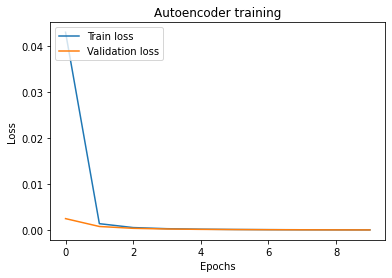

In [ ]:
plot_train_trend(loss_train, loss_val, "Autoencoder training")

**Encode data**

In [ ]:
#Take the train set and encode it

new_set = []
new_out = []
for x, y, index, lenghts in dataset_train_svm:

  #encode data
  with torch.no_grad():
    input = {k: v.type(torch.long).to(device) for k, v in x.items()}
    out_encoded, _ = model(input, encode=True)

    #build a new representation without pad
    for output,mask,i,l in zip(out_encoded,input["attention_mask"],index,lenghts):
      new_representation = []
      
      #extract pronoun and entity
      for o,m in zip(output,mask):
        if m.item() == 1:
          new_representation.append(o)

      #take the pronoun and the entity in question to classify
      i1 = i[0]
      i2 = i[1]
      if i1 is not None:
        if l>1: #if the entity has more than one token
          o1 = torch.stack(new_representation[i1:i1+l])
          o1 = torch.mean(o1) #take the mean of the tokens
        else:
          o1 = new_representation[i1]
      else:
        o1 = torch.mean(output, -2) #if entity not found take the mean of all words

      if i2 is not None:
        o2 = new_representation[i2] 
      else:
        o2 = torch.mean(output, -2) #if pronoun not found take the mean of all words

      new_out.append((o1+o2))

new_set=torch.stack(new_out)

In [ ]:
#Take the dev set and encode it

new_set_dev = []
new_out = []
for x, y, index, lenghts in dataset_dev_svm:
  with torch.no_grad():
    input = {k: v.type(torch.long).to(device) for k, v in x.items()}
    out_encoded, _ = model(input, encode=True)

    #encode data
    for output,mask,i,l in zip(out_encoded,input["attention_mask"],index,lenghts):
      new_representation = []
      
      #build a new representation without pad
      for o,m in zip(output,mask):
        if m.item() == 1:
          new_representation.append(o)
      
      #take the pronoun and the entity in question to classify
      i1 = i[0]
      i2 = i[1]
      if i1 is not None:
        if l>1:  #if the entity has more than one token
          o1 = torch.stack(new_representation[i1:i1+l])
          o1 = torch.mean(o1) #take the mean of the tokens
        else:
          o1 = new_representation[i1]
      else:
        o1 = torch.mean(output, -2) #if entity not found take the mean of all words

      if i2 is not None:
        o2 = new_representation[i2]
      else:
        o2 = torch.mean(output, -2) #if pronoun not found take the mean of all words

      new_out.append((o1+o2))

new_set_dev=torch.stack(new_out)

In [ ]:
#Transform output for SVM input
outputs = new_set.cpu().detach().numpy()
outputs_dev = new_set_dev.cpu().detach().numpy()

**Try different kernels of SVM**

In [ ]:
#Define the SVM classifier
svm1 = SVC(kernel='linear')
svm1.fit(outputs, labels)
predictions = svm1.predict(outputs_dev)

In [ ]:
test_SVM(predictions, labels_dev)

Identified correctly: 518
Tot: 908
# Precision: 0.6667
# Recall: 0.0102
# F1: 0.0201
# accuracy: 0.5705


In [ ]:
#Define the SVM classifier
svm2 = SVC(kernel='poly', degree=5, C=100)
svm2.fit(outputs, labels)
predictions = svm2.predict(outputs_dev)

In [ ]:
test_SVM(predictions, labels_dev)

Identified correctly: 516
Tot: 908
# Precision: 0.5000
# Recall: 0.0026
# F1: 0.0051
# accuracy: 0.5683


In [ ]:
#Define the SVM classifier
svm3 = SVC(kernel='sigmoid', C=100)
svm3.fit(outputs, labels)
predictions = svm3.predict(outputs_dev)

In [ ]:
test_SVM(predictions, labels_dev)

Identified correctly: 401
Tot: 908
# Precision: 0.3956
# Recall: 0.5561
# F1: 0.4624
# accuracy: 0.4416
